![Py4Eng](img/logo.png)

# Image processing
## Yoav Ram

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import signal, misc
from scipy import ndimage

import skimage.data
from skimage import measure
from skimage import filters
from skimage import morphology

sns.set(style='ticks', context='notebook', font_scale=1.5)
def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])

# Denoising

Here's a salt-and-pepper noisy image of a famous person:

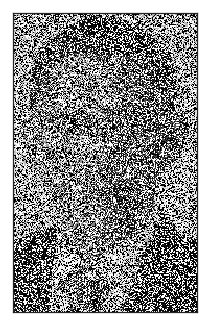

In [57]:
noisy = np.loadtxt(r'../data/noisy.bitmap')
display_image(noisy)

[![SciPy logo](http://space-kerala.org/freeelectron/wp-content/uploads/2013/11/scipyshiny_small.png)](http://scipy.org)

First let's try to denoise it with Scipy's median filter:

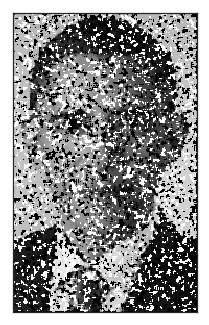

In [58]:
denoised = signal.medfilt2d(noisy)
display_image(denoised)

[![scikit-image](http://scikit-image.org/docs/stable/_static/img/logo.png)](http://scikit-image.org/)

Now using Scikit-image:

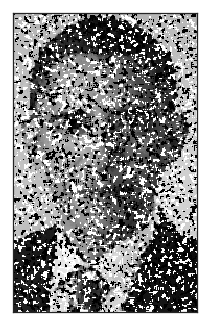

In [59]:
display_image(filters.median(noisy.astype(np.uint16), square(3)))

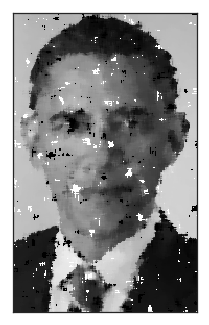

In [60]:
display_image(filters.median(noisy.astype(np.uint16), square(7)))

## Bounded median

Now let's apply our own bounded median filter.

We want to replace the value of each outlier (noisy) pixel with the median of non-outlier neighbors. We'll write to functions, one to do it for white pixels and one for black pixels:

In [61]:
def fix_white(arr, white_th):
    center = arr.size // 2
    if arr[center] > white_th:
        bounded = arr[arr <= white_th]
        if bounded.size:
            return np.median(bounded)
    # either center was not extreme or all its neighbors are extreme
    return arr[center]

def fix_black(arr, black_th):
    center = arr.size // 2
    if arr[center] < black_th:
        bounded = arr[arr >= black_th]
        if bounded.size:
            return np.median(bounded)
    # either center was not extreme or all its neighbors are extreme
    return arr[center]

To apply these functions to each pixel we use SciPy's `generic_filter`, which accepts an image, a neighborhood definition, and a function to apply on the neighborhood to determine the pixel value.

In [62]:
from scipy.ndimage import generic_filter
generic_filter?

In [63]:
def bounded_median(image, k=1, black_th=10, white_th=250):
    n = 2 * k + 1
    res = generic_filter(image, fix_white, size=(n, n), extra_keywords={'white_th': white_th})
    res = generic_filter(res, fix_black, size=(n, n), extra_keywords={'black_th': black_th})
    return res

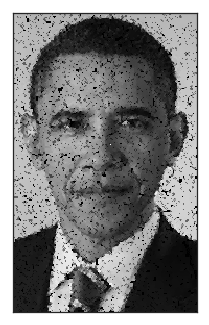

In [64]:
denoised = bounded_median(noisy)
display_image(denoised)

That's much better!

## Exercise

Use `generic_filter` to apply a **dilation** filter on the following horse image: replace each pixel with the maximum of it's neighborhood.

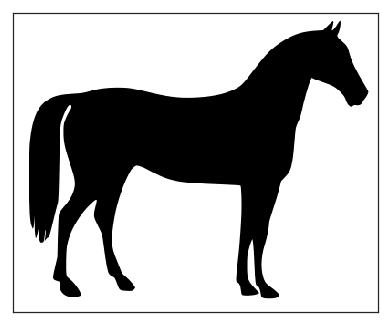

In [65]:
import skimage.data
horse = skimage.data.horse()[:,:,0]
display_image(horse)

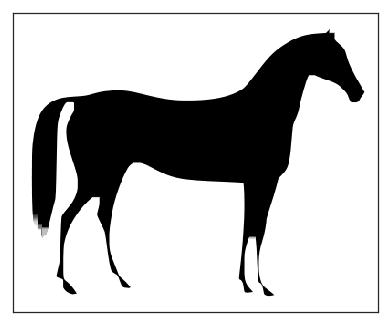

In [67]:

display_image(dilated)

## Adding salt and pepper noise

Here's how the noise was added in the first place:

In [68]:
def salt_pepper(image, p=0.01):
    """Generates salt and pepper noise.
    
    Each pixel is "hit" independently with probability `p`. 
    If hit, a pixel has 1:1 chance of becoming white or black.
    """
    noisy = image.copy()
    rand = np.random.random(size=noisy.shape)
    idx = rand <= p/2
    noisy[idx] = 0
    idx = (p/2 < rand) & (rand <= p)
    noisy[idx] = 255
    return noisy

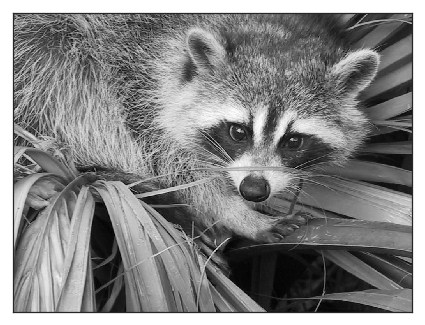

In [69]:
image = misc.face(gray=True)
display_image(image)

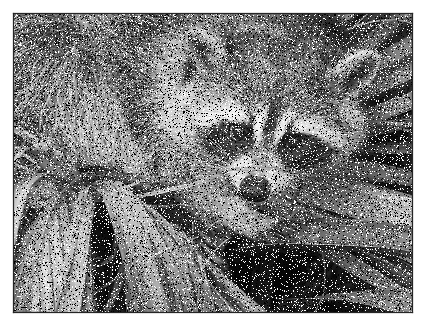

In [70]:
display_image(salt_pepper(image, p=0.2))

# Gaussian filter

Let's apply a gaussian filter for blurring. We'll use this image:

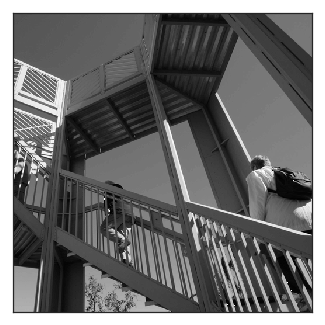

In [71]:
image = misc.ascent()
display_image(image)

## scipy.signal

We define a gaussian window using `scipy.signal.gaussian` of width 50 and $\sigma=10$:

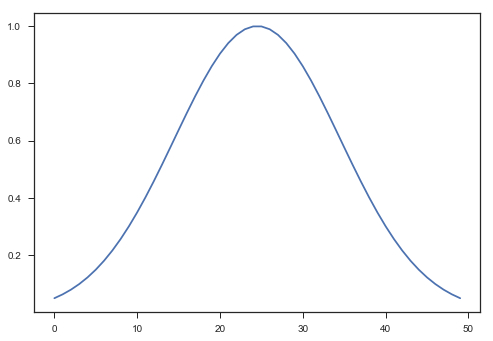

In [72]:
window = signal.gaussian(50, 10)
plt.plot(window);

Because the 2D gaussian filter can be described by the product of two 1D functions, we can use the function `scipy.signal.sepfir2d` to apply the filter:

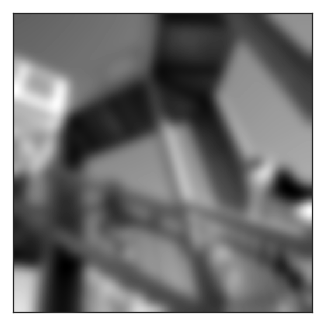

In [73]:
blurred = signal.sepfir2d(image, window, window)
display_image(blurred)

## scikit-image

Scikit-image has a function to apply a  gaussian filter, so let's just use it:

In [74]:
image.min(), image.max()

(0, 255)

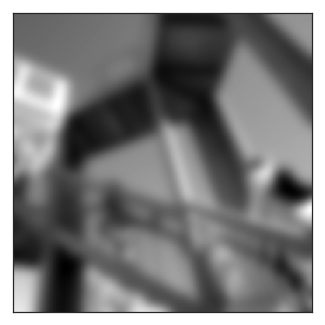

In [75]:
blurred = filters.gaussian(image.astype(np.uint8), sigma=10)
display_image(blurred)

## Exercise

Use one of scikit-image's filters to find edge magnitude in the ascent image (last used image). Plot the result. 

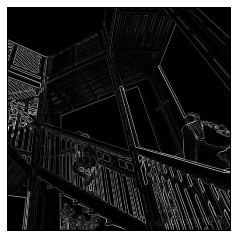

# Labeling

Now we will find objects in an image, and measure their sizes.

We'll work with the greek coins image from the scikit-image package.

Shape (303, 384)


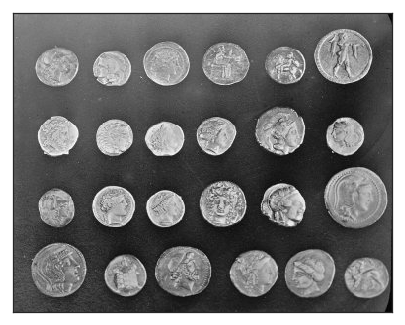

In [3]:
img = skimage.data.coins()
print("Shape", img.shape)
display_image(img)

First, we do a binary segmentation. Here I use a static threshold, but we could use something more clever from `skimage.filters` like `threshold_otsu` but in this case it works better to set the threshold to 120:

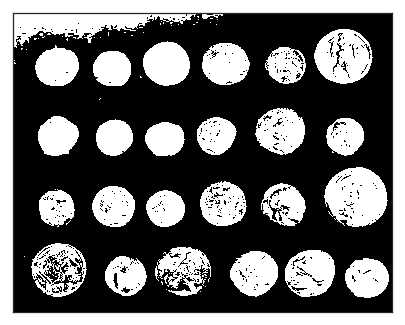

In [4]:
th = 120
bw = img > th
display_image(bw)

Next we use a dilation operator to (our own from before!) to clean up the coins.

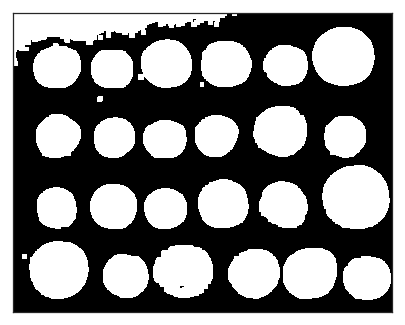

In [5]:
dilated = morphology.dilation(bw, morphology.square(5))
display_image(dilated)

Now we do the labeling using `skimage.measure.label` (you can also use`scipy.ndimage.label`):

In [6]:
labels = measure.label(dilated)
len(labels)

303

The `labels` array specifies the label of each pixel, so we can plot it using a qualitative colormap to view the labels:

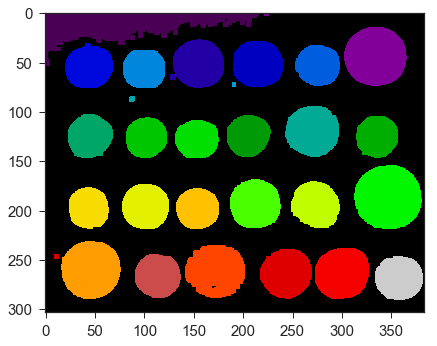

In [7]:
plt.imshow(labels, cmap=plt.cm.spectral);

We can use `skimage.measure.regionprops` to measure the properties of the labeled coins, such as their centroid, for adding a text label to the plot, and the area, to filter out small labels:

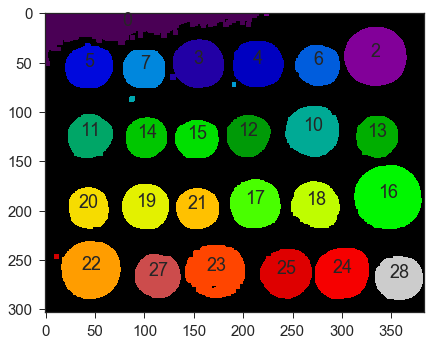

In [8]:
label_props = measure.regionprops(labels)
plt.imshow(labels, cmap=plt.cm.spectral)
for i, props in enumerate(label_props):
    if props.area < 500: 
        continue
    y, x = props.centroid
    plt.text(x, y, i, fontdict={'horizontalalignment':'center'})

Or we can plot a histogram of the areas:

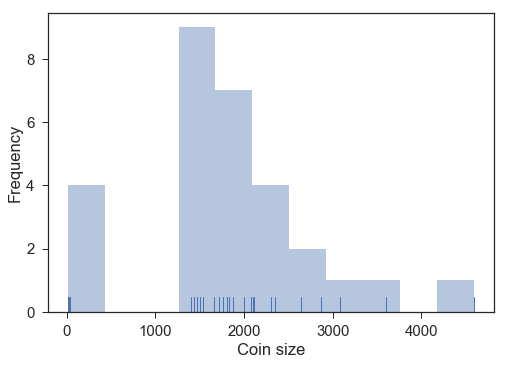

In [9]:
areas = [props.area for props in label_props]
sns.distplot(areas, kde=False, rug=True)
plt.xlabel('Coin size')
plt.ylabel('Frequency')

# References

- [Scipy.Signal tutorial](https://scipy.github.io/devdocs/tutorial/signal.html)
- [Scipy.ndimage docs](https://docs.scipy.org/doc/scipy/reference/ndimage.html)
- [Scipy.ndimage tutorial](https://docs.scipy.org/doc/scipy-0.17.0/reference/tutorial/ndimage.html)
- [Scikit-Image docs](http://scikit-image.org/docs/0.11.x/)

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)